# Implement Personalized Pagerank

[1] A. Langville and C. Meyer, “A survey of eigenvector methods of web information retrieval.” http://citeseer.ist.psu.edu/713792.html

[2] Page, Lawrence; Brin, Sergey; Motwani, Rajeev and Winograd, Terry, The PageRank citation ranking: Bringing order to the Web. 1999 http://dbpubs.stanford.edu:8090/pub/showDoc.Fulltext?lang=en&doc=1999-66&format=pdf


In [45]:
from PageRank_modules import utils as pr_utils
from PageRank_modules import pageranker as pr_module

In [5]:
from abc import ABC, abstractmethod
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

import pickle
import random

from collections import defaultdict

## Read in files

In [10]:
subgraph_hci = pr_utils.read_g_obj(file="adj_matrices/G_hci.pkl", min_following=15)

Min out degree -- person vegabs : 	 followers: 0
Min out degree -- person denniswittchen : 	 followers: 9
Min out degree -- person PipzCorreiaz : 	 followers: 13
Min out degree -- person wafajohal : 	 followers: 14
Min out degree -- person katiewinkle : 	 followers: 14
Min out degree -- person catvajiac : 	 followers: 15


In [11]:
# this is the subgraph of the hci graph based on the "15 out core"

len(subgraph_hci.edges)

25373

In [12]:
with open("train_test/new_folds/train-0.pkl", "rb") as pfile: 
    train = pickle.load(pfile)

In [13]:
with open("train_test/new_folds/test-0.pkl", "rb") as pfile: 
    test = pickle.load(pfile)

## Reconstruct Graph

In [14]:
G_train = nx.from_edgelist(train, create_using=nx.DiGraph)

In [15]:
# ok good, there is list 70% of the edges missing!
len(G_train.edges)

17028

In [16]:
# make sure no test set leakage

any([train_edge in test for train_edge in list(G_train.edges)])

False

Ok good, none of the test edges are in the train edges

### Check this with a teeny graph

In [36]:
small_graph = nx.barabasi_albert_graph(20, 3, seed=20231211).to_directed()

In [37]:
small_graph.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19))

In [38]:
len(small_graph.edges())

102

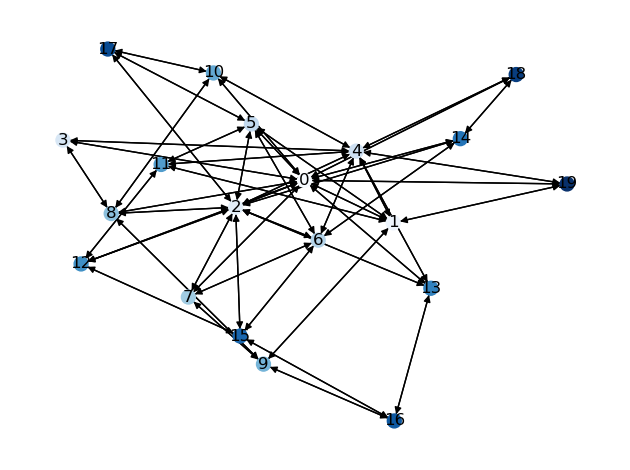

In [39]:
full_small_graph = small_graph.to_directed()

fig, ax = plt.subplots()

nx.draw(
    full_small_graph, 
    pos=nx.spring_layout(full_small_graph, seed=2023),
    ax=ax,
    with_labels=True, 
    node_color=range(len(full_small_graph.nodes)), 
    node_size=100,
    cmap=plt.cm.Blues
)

plt.tight_layout()
plt.show()

fig.savefig('graph_images/full.png', bbox_inches='tight')

plt.close()

In [40]:
small_test_set = []

for _ in range(len(small_graph.edges())//3):
    edge = random.choice(list(small_graph.edges()))
    
    small_test_set.append(edge)
    small_graph.remove_edges_from([edge])
    

print(len(small_test_set))

34


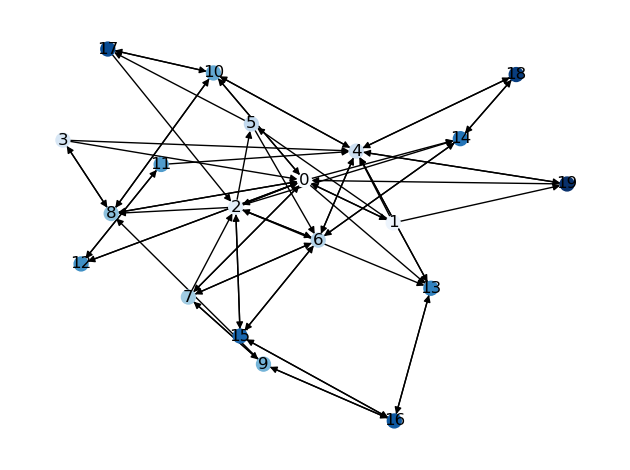

In [41]:
fig, ax = plt.subplots()

nx.draw(
    small_graph, 
    pos=nx.spring_layout(full_small_graph, seed=2023),
    ax=ax,
    with_labels=True, 
    node_color=range(len(full_small_graph.nodes)), 
    node_size=100,
    cmap=plt.cm.Blues
)

plt.tight_layout()
plt.show()

fig.savefig('graph_images/train.png', bbox_inches='tight')

plt.close()

In [42]:
len(small_graph.edges)

68

In [43]:
# this has been downsampled!
edge_colors = ["black"] * len(small_graph.edges)

for edge in small_test_set:
    
    full_small_graph.add_edges_from([edge])
    # run again for red edges
    edge_colors.append("red")
    

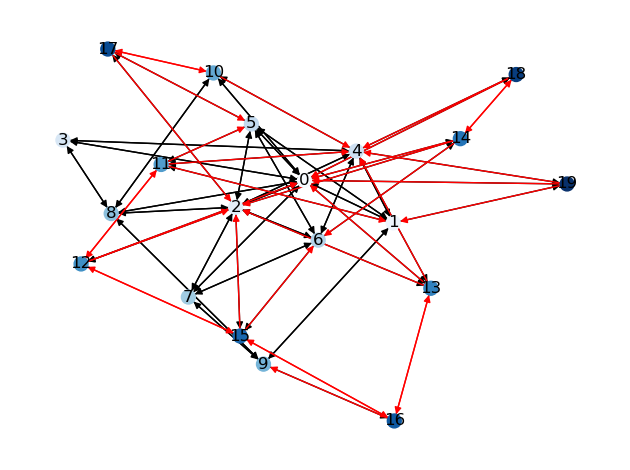

In [44]:
fig, ax = plt.subplots()

nx.draw(
    full_small_graph, 
    pos=nx.spring_layout(full_small_graph, seed=2023),
    ax=ax,
    with_labels=True, 
    node_color=range(len(full_small_graph.nodes)), 
    node_size=100,
    cmap=plt.cm.Blues,
    edge_color=edge_colors
)

plt.tight_layout()

plt.show()

# change this!
fig.savefig('graph_images/test.png', bbox_inches='tight')

plt.close()

### Try PageRank on this small graph

In [46]:
pageranker = pr_module.PageRanker(full_small_graph)

In [47]:
pageranker.test(personalized=False)

{'overall': [(0, 0.10947449577524604),
  (1, 0.0576322916316715),
  (2, 0.09975350867741745),
  (3, 0.031611675034258165),
  (4, 0.0840614640278401),
  (5, 0.056784129581778475),
  (6, 0.05700424478861464),
  (7, 0.040002195696391976),
  (8, 0.0495212189376021),
  (9, 0.042182038926992134),
  (10, 0.04064713356044414),
  (11, 0.04021514917407933),
  (12, 0.040316615534240166),
  (13, 0.04050031826115623),
  (14, 0.04001943025994371),
  (15, 0.041449944618288576),
  (16, 0.03387847661942117),
  (17, 0.03189054232769133),
  (18, 0.03169731501410088),
  (19, 0.03135781155282181)]}

In [48]:
test_recs = pageranker.test(personalized=True)

In [50]:
tr = pr_module.TestRecommendations(small_graph)
k = 5

In [51]:
tr.setup(test_recs, k=k)

In [57]:
who_to_look_at = 1

list(tr.iter_recs())[who_to_look_at]

(0,
 [(4, 0.06910174091082645),
  (5, 0.04983437486498709),
  (6, 0.04193248084222645),
  (18, 0.03229799914272357),
  (3, 0.0320189049707555)])

In [58]:
# 0's outlinks in the test set
[v for u, v in small_test_set if u == who_to_look_at]

[9, 11]

So we got this right for this person!

### Evaluate the little graph

In [59]:
ndcg = pr_module.NDCGEvaluator(k=k)

In [60]:
ndcg.setup(trainset=None, testset=small_test_set)

In [61]:
ndcg.evaluate(tr)

In [62]:
ndcg.score

0.6073114587466497

I think this kind of graph is more or less the ideal case for this algorithm!

### Try again for precision

In [63]:
precision = pr_module.PrecisionEvaluator()

In [64]:
precision.setup(trainset=None, testset=small_test_set)

In [65]:
precision.evaluate(tr)

In [66]:
precision.score

0.2857142857142857

## Try it on the HCI social network

In [67]:
# make a personalized page ranker
pageranker_hci = pr_module.PageRanker(G_train)

In [68]:
# actually make the lists
hci_test_recs = pageranker_hci.test(personalized=True)

In [70]:
tr_hci = pr_module.TestRecommendations(G_train)
k = 10

In [71]:
tr_hci.setup(hci_test_recs, k=k)

In [72]:
list(tr_hci.iter_recs())[0]

('cbuntain',
 [('jbigham', 0.011984054742166069),
  ('andresmh', 0.011654960967647015),
  ('msbernst', 0.009539180488987156),
  ('eglassman', 0.008449476787533045),
  ('Niloufar', 0.006940979427360863),
  ('karger', 0.006650893620964772),
  ('asb', 0.006468840895790867),
  ('evanmpeck', 0.006405555816816929),
  ('jordant', 0.006276794622233653),
  ('vitak', 0.00584314443071665)])

I think these are mostly just the popular people, but I think they are reasonable good tbh

### Evaluate on the hci.social network!

#### NDCG

In [73]:
ndcg_hci = pr_module.NDCGEvaluator(k=k)

In [74]:
ndcg_hci.setup(trainset=None, testset=test)

In [75]:
ndcg_hci.evaluate(tr_hci)

In [76]:
ndcg_hci.score

0.4022244068634785

#### Precision

In [77]:
precision_hci = pr_module.PrecisionEvaluator()

In [78]:
precision_hci.setup(trainset=None, testset=test)

In [79]:
precision_hci.evaluate(tr_hci)

In [80]:
precision_hci.score

0.22959183673469388

### What were our predictions?

In [81]:
predictions_for_group_members = {person : recs for person, recs in list(tr_hci.iter_recs()) if person in ["MattNicholson", "Anas", "joshua_paup"]}

In [82]:
predictions_for_group_members

{'Anas': [('jbigham', 0.0129405063829669),
  ('msbernst', 0.009535475306459042),
  ('sigchi', 0.00881733602709077),
  ('eglassman', 0.007474231944641113),
  ('karger', 0.006316854780741633),
  ('drmaxlwilson', 0.006220090097173897),
  ('asb', 0.006137423083614284),
  ('jordant', 0.005662327658579726),
  ('floe', 0.00548337071211692),
  ('Niloufar', 0.0053932125409089674)],
 'MattNicholson': [('jbigham', 0.013112330800192872),
  ('andresmh', 0.012307144610683463),
  ('cfiesler', 0.011105116108353928),
  ('bkeegan', 0.008858869669581874),
  ('karger', 0.006968142988532277),
  ('asb', 0.006834586132616978),
  ('schaferj', 0.006397068841239488),
  ('jordant', 0.005996661796079625),
  ('drmaxlwilson', 0.00560668573945307),
  ('Niloufar', 0.005538466985766061)]}

In [83]:
pr_utils.check_predictions(predictions_for_group_members, test)

{'Anas': {'predicted': ['jbigham',
   'msbernst',
   'sigchi',
   'eglassman',
   'karger',
   'drmaxlwilson',
   'asb',
   'jordant',
   'floe',
   'Niloufar'],
  'correct': ['jbigham', 'karger'],
  'should_follow': ['msbernst',
   'sigchi',
   'eglassman',
   'drmaxlwilson',
   'asb',
   'jordant',
   'floe',
   'Niloufar']},
 'MattNicholson': {'predicted': ['jbigham',
   'andresmh',
   'cfiesler',
   'bkeegan',
   'karger',
   'asb',
   'schaferj',
   'jordant',
   'drmaxlwilson',
   'Niloufar'],
  'correct': ['karger', 'schaferj', 'jordant'],
  'should_follow': ['jbigham',
   'andresmh',
   'cfiesler',
   'bkeegan',
   'asb',
   'drmaxlwilson',
   'Niloufar']}}

In [84]:
len(G_train.edges("MattNicholson"))

15

In [85]:
matt_test_links = [v for u, v in test if u in ["MattNicholson"]]

In [86]:
matt_test_links

['estellesmith',
 'davidthewid',
 'andrewkuznet',
 'karger',
 'denniswang',
 'schaferj',
 'jordant']

## It works and I used that info already! Do some box plots!

In [87]:
hci_ndcg_scores = []
hci_precision_scores = []
k = 5

file_path = "train_test/new_folds/"

subgraph_hci = pr_utils.read_g_obj(file="adj_matrices/G_hci.pkl", min_following=15)

for fold in ["-0", "-1", "-2", "-3", "-4"]:
    
    print("Starting fold{}".format(fold))
    
    with open(file_path + "train{}.pkl".format(fold), "rb") as pfile: 
        this_fold_train = pickle.load(pfile)
    
    with open(file_path + "test{}.pkl".format(fold), "rb") as pfile: 
        this_fold_test = pickle.load(pfile)
    
    # make the graph
    G_train_this_fold = nx.from_edgelist(this_fold_train, create_using=nx.DiGraph)
    
    print("Made graph")
    
    # make sure we did this right
    assert len(G_train_this_fold.edges) > 15000 and len(G_train_this_fold.edges) < 20000
    
    # make my pagerank objects
    this_pageranker_hci = pr_module.PageRanker(G_train_this_fold)
    
    # actually make the lists
    hci_this_fold_test_recs = this_pageranker_hci.test(personalized=True)
    
    print("done making pagerank recs")
    
    # make the test recs
    this_fold_tr_hci = pr_module.TestRecommendations(G_train_this_fold)
    this_fold_tr_hci.setup(hci_this_fold_test_recs, k=k)
    
    # --- evaluate ----
    
    # NDCG
    this_fold_ndcg_hci = pr_module.NDCGEvaluator(k=k)
    this_fold_ndcg_hci.setup(trainset=None, testset=this_fold_test)
    
    this_fold_ndcg_hci.evaluate(this_fold_tr_hci)
    
    hci_ndcg_scores.append(this_fold_ndcg_hci.score)
    
    # Precision
    this_fold_precision_hci = pr_module.PrecisionEvaluator()
    this_fold_precision_hci.setup(trainset=None, testset=this_fold_test)
    
    this_fold_precision_hci.evaluate(this_fold_tr_hci)
    
    hci_precision_scores.append(this_fold_precision_hci.score)
    
    
    print("NDCG: {} \t Precision: {}".format(this_fold_ndcg_hci.score, this_fold_precision_hci.score)) 
    
    
    

Min out degree -- person vegabs : 	 followers: 0
Min out degree -- person denniswittchen : 	 followers: 9
Min out degree -- person PipzCorreiaz : 	 followers: 13
Min out degree -- person wafajohal : 	 followers: 14
Min out degree -- person katiewinkle : 	 followers: 14
Min out degree -- person catvajiac : 	 followers: 15
Starting fold-0
Made graph
done making pagerank recs
NDCG: 0.4584862550633868 	 Precision: 0.22959183673469388
Starting fold-1
Made graph
done making pagerank recs
NDCG: 0.4562285714202517 	 Precision: 0.23299319727891157
Starting fold-2
Made graph
done making pagerank recs
NDCG: 0.4314099611369342 	 Precision: 0.22363945578231292
Starting fold-3
Made graph
done making pagerank recs
NDCG: 0.44792975643221733 	 Precision: 0.22108843537414966
Starting fold-4
Made graph
done making pagerank recs
NDCG: 0.46682798651346635 	 Precision: 0.2465986394557823


In [88]:
hci_ndcg_scores

[0.4584862550633868,
 0.4562285714202517,
 0.4314099611369342,
 0.44792975643221733,
 0.46682798651346635]

In [89]:
hci_precision_scores

[0.22959183673469388,
 0.23299319727891157,
 0.22363945578231292,
 0.22108843537414966,
 0.2465986394557823]

Text(0.5, 0.98, 'Precision and nDCG Across 5 folds of the HCI Social Graph')

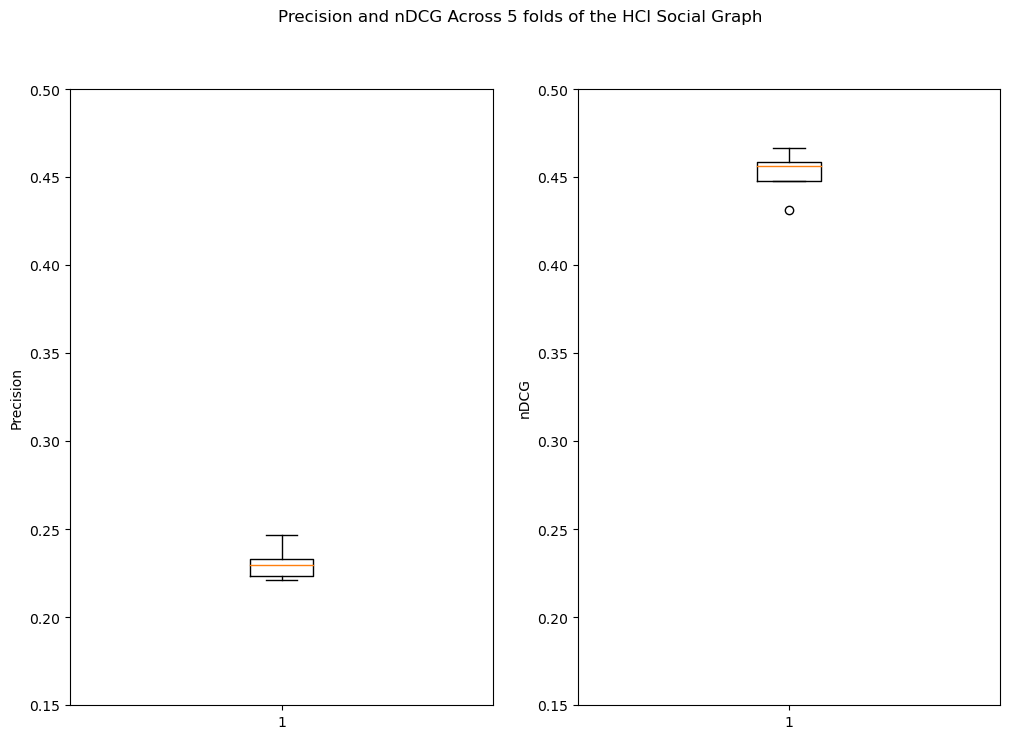

In [90]:
fig, ax = plt.subplots(ncols=2, figsize =(12, 8))

ax[0].boxplot(hci_precision_scores)

ax[1].boxplot(hci_ndcg_scores)

ax[0].set_ylim(0.15,0.5)
ax[1].set_ylim(0.15,0.5)

ax[0].set_ylabel("Precision")
ax[1].set_ylabel("nDCG")


fig.suptitle("Precision and nDCG Across 5 folds of the HCI Social Graph")

In [91]:
out_degree_sequence = sorted((d for n, d in subgraph_hci.out_degree()), reverse=True)
out_d_max = max(out_degree_sequence)

in_degree_sequence = sorted((d for n, d in subgraph_hci.in_degree()), reverse=True)
in_d_max = max(in_degree_sequence)

Text(0.5, 0, 'Rank')

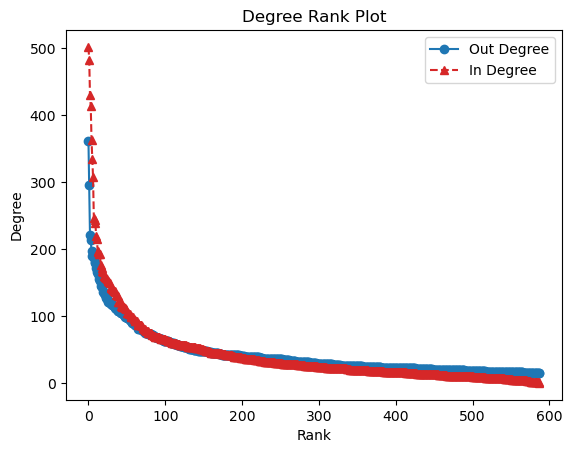

In [92]:
fig, ax = plt.subplots()
ax.plot(out_degree_sequence, color='tab:blue', marker='o', linestyle='solid', alpha=1, label="Out Degree")
ax.plot(in_degree_sequence, color='tab:red', marker='^', linestyle='dashed', alpha=1, label="In Degree")

ax.legend()

ax.set_title("Degree Rank Plot")
ax.set_ylabel("Degree")
ax.set_xlabel("Rank")


This is really good, but it is probably just recommending really popular people!


### Possible TODO: NDCG should be weighted maybe 
- NDCG normally goes from 0 to 1
- if we weight (either way), the "best" score is no longer 1


#### way 1 -- weight for the user
We are weighting nodes that have fewer connection more highly

evaluate(predictions for a user) * how much we should weight that user
evaluate(predictions for a user) * (kappa) / (len(G_train.edges("for that user")) + kappa)
evaluate(predictions for a user) * (kappa) / (len(G_train.edges("for that user")) + kappa)
sum([0.5, 0.25, 0.125, 0, 0])  * (kappa) / (len(G_train.edges("for that user")) + kappa)
1  * (kappa) / (len(G_train.edges("for that user")) + kappa)


u1 NCDG of 1 * (20) / (10 + 20) == 0.67
u2 NCDG of 1 * 20 / (80 + 20) == 0.2

this the best they could do! 

(ndcg for user 1 * weight1 + ndcg for user2 * weight2)/ (weight1 + weight2)

in the case where all are weighted equally
(ndcg for user 1 + ndcg for user2 )/ (n users)


def evaluate_user(user, set_of_recommendation, should_we_weight, kappa=20):
    
    # compute ndcg (and precision?) like normal
    
    # if should_we_weight:
        # compute this persons weight =  (kappa) / (len(G_train.edges("for that user")) + kappa)
    else
        weight = 1
    
    
    return (ndcg * weight, weight)


#### way 2 -- weight for each thing the list
We are weighting nodes that have fewer connection more highly

sum([0.5 * (kappa) / (len(G_train.edges("for that person you are following")) + kappa), 0.25, 0.125, 0, 0])

